In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 0. Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, brier_score_loss, classification_report

In [ ]:
# 1. Load cleaned panel from my part B(parquet from ETL)
df = pd.read_parquet('/content/drive/MyDrive/silo_agg/output/sa_daily_panel.parquet')

def print_intro():
    print("Loaded panel with", df.shape[0], "rows and", df.shape[1], "columns.")
print_intro()


Loaded panel with 19516 rows and 7 columns.


Load New data:

In [ ]:
!pip install -q --upgrade earthengine-api geopandas shapely

import ee, geopandas as gpd, pandas as pd, os, math, json
from pathlib import Path

PROJECT_ID = "hackathonwenzewhen2meet"
GEOJSON_PATH = "nrm_regions.geojson"


In [ ]:
# AUTH + INIT
try:
    # I first initialize directly, which works if the credentials are cached
    ee.Initialize(project=PROJECT_ID)
    print("[OK] Initialized with cached credentials.")
except Exception as e:
    print("[Info] Cached init failed - authenticating:", e)
    ee.Authenticate()
    ee.Initialize(project=PROJECT_ID)
    print("[OK] Initialized after authentication.")

# Jsut quick smoke
print("Algorithms loaded:", len(ee.data.getAlgorithms()))


[OK] Initialized with cached credentials.
Algorithms loaded: 985


In [ ]:
!pip install -q geopandas shapely pyproj fiona
import geopandas as gpd, pandas as pd, numpy as np, os, re
from pathlib import Path


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 127.0 MB/s eta 0:00:00


In [ ]:
SHP_PATH = Path("/content/drive/MyDrive/silo_agg/nrm_superclusters/ADMIN_NrmRegions_GDA2020.shp")
assert SHP_PATH.exists(), f"Shapefile not found: {SHP_PATH}"
print("Shapefile found:", SHP_PATH)

Shapefile found: /content/drive/MyDrive/silo_agg/nrm_superclusters/ADMIN_NrmRegions_GDA2020.shp


In [ ]:
gdf = gpd.read_file(SHP_PATH)
print("CRS:", gdf.crs)
print("Columns:", gdf.columns.tolist())
print(gdf.head(2))

CRS: EPSG:7844
Columns: ['REGION_ID', 'NAME', 'OFFICE_ID', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']
   REGION_ID                         NAME  OFFICE_ID  SHAPE_Leng  SHAPE_Area  \
0        6.0  South Australian Arid Lands       35.0   37.976913   48.464081   
1        2.0          Alinytjara Wilurara       12.0   28.735758   26.186283   

                                            geometry  
0  POLYGON ((141.00404 -25.99928, 141.00557 -26.8...  
1  POLYGON ((133.83383 -29.52227, 133.83384 -29.5...  


In [ ]:
import pandas as pd
panel = pd.read_parquet('/content/drive/MyDrive/silo_agg/output/sa_daily_panel.parquet')
print(panel.columns)
print(panel['region'].head() if 'region' in panel.columns else
      panel[['nrm_id','nrm_name']].head() if {'nrm_id','nrm_name'}.issubset(panel.columns) else
      panel.head())


Index(['date', 'nrm_id', 't2m_K', 'wind_ms', 'rh_pct', 'hotspot_cnt',
       'target_next_day'],
      dtype='object')
        date  nrm_id       t2m_K   wind_ms     rh_pct  hotspot_cnt  \
0 2014-01-03       1  291.021552  6.619956  65.581457          0.0   
1 2014-01-04       1  289.782428  5.629855  50.956166          0.0   
2 2014-01-05       1  291.271989  8.510249  51.713904          0.0   
3 2014-01-10       1  301.997590  2.107849  42.423605          0.0   
4 2014-01-11       1  296.392980  2.938075  46.898584          0.0   

   target_next_day  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  


In [ ]:
!ls -1 drive/MyDrive/silo_agg/nrm_superclusters

ADMIN_NrmRegions_GDA2020.cpg
ADMIN_NrmRegions_GDA2020.dbf
ADMIN_NrmRegions_GDA2020.prj
ADMIN_NrmRegions_GDA2020.sbn
ADMIN_NrmRegions_GDA2020.sbx
ADMIN_NrmRegions_GDA2020.shp
ADMIN_NrmRegions_GDA2020.shp.xml
ADMIN_NrmRegions_GDA2020.shx
ADMIN_NrmRegions_GDA94.cpg
ADMIN_NrmRegions_GDA94.dbf
ADMIN_NrmRegions_GDA94.prj
ADMIN_NrmRegions_GDA94.sbn
ADMIN_NrmRegions_GDA94.sbx
ADMIN_NrmRegions_GDA94.shp
ADMIN_NrmRegions_GDA94.shp.xml
ADMIN_NrmRegions_GDA94.shx
CC_BY.txt
nrm_sa.zip


In [ ]:
import os
print("GeoJSON exists?", os.path.exists("nrm_regions.geojson"))
!head -n 5 nrm_regions.geojson


GeoJSON exists? True
{
"type": "FeatureCollection",
"name": "nrm_regions",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [


In [ ]:
import os, pandas as pd

RAW_PANEL = "/content/drive/MyDrive/silo_agg/output/sa_daily_panel.parquet"
assert os.path.exists(RAW_PANEL), f"Raw panel not found: {RAW_PANEL}"

# Load raw panel
panel = pd.read_parquet(RAW_PANEL)

# Harmonisation (build required columns)
panel['date'] = pd.to_datetime(panel['date'])
panel = panel.sort_values(['nrm_id','date']).reset_index(drop=True)

panel['region']       = panel['nrm_id'].astype(int).astype(str)
panel['mean_temp']    = panel['t2m_K'] - 273.15
panel['rel_humidity'] = panel['rh_pct']
panel['wind_speed']   = panel['wind_ms']
panel['hotspots']     = panel['hotspot_cnt'].fillna(0).astype(float)

panel['hotspots_next']   = panel.groupby('region')['hotspots'].shift(-1)
panel['target_next_day'] = (panel['hotspots_next'] >= 10).astype(int)
panel = panel.dropna(subset=['hotspots_next'])

print("Harmonised panel shape:", panel.shape,
      "| Positive rate:", f"{panel['target_next_day'].mean():.2%}")

# Save to Drive
panel.to_parquet("panel_harmonised.parquet", index=False)
panel.to_parquet("/content/drive/MyDrive/silo_agg/output/panel_harmonised.parquet", index=False)
print("Saved panel_harmonised.parquet to working dir and Drive.")


Harmonised panel shape: (19508, 13) | Positive rate: 1.63%
Saved panel_harmonised.parquet to working dir and Drive.


In [ ]:
import os, shutil

LOCAL_GEOJSON = "nrm_regions.geojson"
DRIVE_GEOJSON_DIR = "/content/drive/MyDrive/silo_agg/nrm_superclusters"
DRIVE_GEOJSON = os.path.join(DRIVE_GEOJSON_DIR, "nrm_regions.geojson")

os.makedirs(DRIVE_GEOJSON_DIR, exist_ok=True)
print("Drive target directory:", DRIVE_GEOJSON_DIR)


Drive target directory: /content/drive/MyDrive/silo_agg/nrm_superclusters


In [ ]:
assert os.path.exists(LOCAL_GEOJSON), "Local GeoJSON missing. Re-create it first."
shutil.copy2(LOCAL_GEOJSON, DRIVE_GEOJSON)
print("Copied to Drive:", DRIVE_GEOJSON, "| Size (bytes):", os.path.getsize(DRIVE_GEOJSON))


Copied to Drive: /content/drive/MyDrive/silo_agg/nrm_superclusters/nrm_regions.geojson | Size (bytes): 153282


In [ ]:
import geopandas as gpd
gdf_drive = gpd.read_file("/content/drive/MyDrive/silo_agg/nrm_superclusters/nrm_regions.geojson")
print("Regions:", gdf_drive['region'].nunique(), "| First IDs:", gdf_drive['region'].head().tolist())


Regions: 8 | First IDs: ['6', '2', '7', '5', '3']


In [ ]:
import geopandas as gpd, os
SRC = "nrm_regions.geojson"
SIMPL = "nrm_regions_simplified.geojson"
gdf = gpd.read_file(SRC).to_crs(4326)
try:
    gdf['geometry'] = gdf.geometry.simplify(0.002, preserve_topology=True)
except Exception as e:
    print("Simplify skipped:", e)
gdf[['region','geometry']].to_file(SIMPL, driver="GeoJSON")
print("Saved simplified:", SIMPL, "Regions:", len(gdf))


Saved simplified: nrm_regions_simplified.geojson Regions: 8


In [ ]:
import ee
PROJECT_ID = "hackathonwenzewhen2meet"
ee.Initialize(project=PROJECT_ID)

In [ ]:
import time, geopandas as gpd, ee

REGIONS_GEOJSON = "nrm_regions_simplified.geojson"
DATASET         = "COPERNICUS/S2_SR_HARMONIZED"
START_YEAR, END_YEAR = 2014, 2024
WINDOW_DAYS     = 5
CLOUD_PCT       = 70
SCALE           = 20
TILESCALE       = 8
FOLDER          = "silo_agg_output"

gdf_all = gpd.read_file(REGIONS_GEOJSON).to_crs(4326)

def gdf_to_fc(gdf_):
    feats = [ee.Feature(ee.Geometry(r.geometry.__geo_interface__), {'region': r['region']})
             for _, r in gdf_.iterrows()]
    return ee.FeatureCollection(feats)

fc_regions = gdf_to_fc(gdf_all)

# Based on the characteristics of my Part C, I only use the scene classification layer for masking.
# Retain: vegetation (4), bare soil (5), water (6)
# Exclude: cloud shadows (3), clouds (8, 9, 10), snow/ice (11), no data (0), defects (1)
def mask_scl(img):
    scl = img.select('SCL')
    good = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6))
    return img.updateMask(good).select(['B4','B8'])

def s2_year(year):
    start, end = f"{year}-01-01", f"{year}-12-31"
    base = (ee.ImageCollection(DATASET)
              .filterDate(start, end)
              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_PCT))
              .select(['B4','B8','SCL'])
              .map(mask_scl)
              .map(lambda im: im.addBands(
                  im.normalizedDifference(['B8','B4']).rename('NDVI')
              )))
    return base

def daily_ic(year):
    base = s2_year(year)
    start = ee.Date(f"{year}-01-01")
    end   = ee.Date(f"{year}-12-31")
    ndays = end.difference(start,'day').add(1)
    offs  = ee.List.sequence(0, ndays.subtract(1))

    def make_day(o):
        d0  = start.advance(o,'day')
        d_start = d0.advance(-(WINDOW_DAYS-1), 'day')
        subset = base.filterDate(d_start, d0.advance(1,'day'))
        size = subset.size()
        def nonempty():
            return subset.median().select('NDVI')
        def empty():
            return ee.Image.constant(ee.Number(-9999)).rename('NDVI').updateMask(ee.Image.constant(0))
        img = ee.Image(ee.Algorithms.If(size.gt(0), nonempty(), empty()))
        return img.set('date', d0.format('yyyy-MM-dd'))
    return ee.ImageCollection(offs.map(make_day))

def export_year(year):
    ic = daily_ic(year)
    def reduce_day(img):
        return img.reduceRegions(fc_regions,
                                 ee.Reducer.mean(),
                                 scale=SCALE,
                                 tileScale=TILESCALE)\
                  .map(lambda f: f.set('date', img.get('date')))
    fc = ic.map(reduce_day).flatten()
    desc = f"S2_NDVI_5d_{year}"
    task = ee.batch.Export.table.toDrive(
        collection=fc,
        description=desc,
        folder=FOLDER,
        fileNamePrefix=desc,
        fileFormat='CSV'
    )
    task.start()
    print("Submitted:", desc)

for y in range(START_YEAR, END_YEAR+1):
    export_year(y)
    time.sleep(5)

print("All re-submitted with robust script.")


Submitted: S2_NDVI_5d_2014
Submitted: S2_NDVI_5d_2015
Submitted: S2_NDVI_5d_2016
Submitted: S2_NDVI_5d_2017
Submitted: S2_NDVI_5d_2018
Submitted: S2_NDVI_5d_2019
Submitted: S2_NDVI_5d_2020
Submitted: S2_NDVI_5d_2021
Submitted: S2_NDVI_5d_2022
Submitted: S2_NDVI_5d_2023
Submitted: S2_NDVI_5d_2024
All re-submitted with robust script.


In [ ]:
import ee, geopandas as gpd, pandas as pd, time, os
ee.Initialize(project="hackathonwenzewhen2meet")

GEOJSON = "nrm_regions_simplified.geojson" if os.path.exists("nrm_regions_simplified.geojson") else "nrm_regions.geojson"
gdf = gpd.read_file(GEOJSON).to_crs(4326)
fc  = ee.FeatureCollection([
    ee.Feature(ee.Geometry(r.geometry.__geo_interface__), {'region': r['region']})
    for _, r in gdf.iterrows()
])

def mask_and_scale(im):
    ndvi_raw = im.select('NDVI')
    valid    = ndvi_raw.gt(-2000)                     # keep > -2000
    ndvi_sc  = ndvi_raw.updateMask(valid).multiply(0.0001).rename('NDVI')
    return ndvi_sc.copyProperties(im, ['system:time_start'])

MODIS = (ee.ImageCollection("MODIS/061/MOD13Q1")
           .filterDate('2014-01-01', '2024-12-31')
           .map(mask_and_scale))

img_list = MODIS.toList(MODIS.size())
n = img_list.size().getInfo()
print("Total composites after masking:", n)

rows=[]
for i in range(n):
    img = ee.Image(img_list.get(i))
    ts  = img.get('system:time_start').getInfo()
    if ts is None:
        continue
    date_str = pd.to_datetime(ts, unit='ms').strftime('%Y-%m-%d')
    feats = img.reduceRegions(fc, ee.Reducer.mean(), scale=250).getInfo()['features']
    for f in feats:
        val = f['properties']['mean']
        if val is not None:
            rows.append((f['properties']['region'], date_str, val))
    if (i+1) % 50 == 0:
        print(f"Processed {i+1}/{n}")
    time.sleep(0.2)

df = pd.DataFrame(rows, columns=['region','date','ndvi_16d'])
df['date'] = pd.to_datetime(df['date'])
out_csv = "/content/drive/MyDrive/silo_agg_output/MODIS_MOD13Q1_NDVI_2014_2024.csv"
os.makedirs(os.path.dirname(out_csv), exist_ok=True)
df.to_csv(out_csv, index=False)
print("Saved CSV - shape:", df.shape)


Total composites after masking: 253
Processed 50/253
Processed 100/253
Processed 150/253
Processed 200/253
Processed 250/253
Saved CSV - shape: (2024, 3)


In [ ]:
import pandas as pd, numpy as np, os

csv_path = "/content/drive/MyDrive/silo_agg_output/MODIS_MOD13Q1_NDVI_2014_2024.csv"
mod = pd.read_csv(csv_path)
mod['date'] = pd.to_datetime(mod['date'])
mod = mod.sort_values(['region','date']).rename(columns={'ndvi_16d':'ndvi_16d'})

daily = []
for region, grp in mod.groupby('region', sort=False):
    grp = grp.set_index('date')
    idx = pd.date_range(grp.index.min(), grp.index.max(), freq='D')
    full = grp.reindex(idx)
    full['region'] = region
    full['ndvi'] = full['ndvi_16d'].interpolate(limit_direction='both')
    daily.append(full.reset_index().rename(columns={'index':'date'}))

daily = pd.concat(daily, ignore_index=True)
print("Daily NDVI:", daily.shape)
daily.to_csv("/content/drive/MyDrive/silo_agg_output/MODIS_NDVI_daily_interp.csv", index=False)


Daily NDVI: (32040, 4)


In [ ]:
import pandas as pd, os

# paths
panel_raw = "/content/drive/MyDrive/silo_agg/output/panel_harmonised.parquet"
ndvi_daily = "/content/drive/MyDrive/silo_agg_output/MODIS_NDVI_daily_interp.csv"

panel = pd.read_parquet(panel_raw)
panel['date'] = pd.to_datetime(panel['date'])

ndvi = pd.read_csv(ndvi_daily, parse_dates=['date'])
panel['region'] = panel['region'].astype(str)
ndvi['region']  = ndvi['region'].astype(str)

panel = panel.merge(ndvi[['region','date','ndvi']], on=['region','date'], how='left')

# The local median value, then global fallback
panel['ndvi'] = panel.groupby('region')['ndvi'].transform(lambda s: s.fillna(s.median()))
panel['ndvi'] = panel['ndvi'].fillna(panel['ndvi'].median())

out_panel_ndvi = "/content/drive/MyDrive/silo_agg/output/panel_with_ndvi.parquet"
panel.to_parquet(out_panel_ndvi, index=False)
print("Panel + NDVI:", panel.shape)


Panel + NDVI: (19508, 14)


Feature Engineering:

In [ ]:
import pandas as pd, geopandas as gpd, numpy as np, os, pathlib

In [ ]:
# SA filter + Feature Engineering
import pandas as pd, geopandas as gpd, numpy as np, os

PANEL_IN  = "/content/drive/MyDrive/silo_agg/output/panel_with_ndvi.parquet"
GEOJSON   = "/content/drive/MyDrive/silo_agg/nrm_superclusters/nrm_regions.geojson"
PANEL_OUT = "/content/drive/MyDrive/silo_agg/output/panel_features_SA.parquet"

In [ ]:
panel = pd.read_parquet(PANEL_IN)
panel['region'] = panel['region'].astype(str)
panel['date']   = pd.to_datetime(panel['date'])

gdf = gpd.read_file(GEOJSON).to_crs(4326)
allowed = gdf['region'].astype(str).unique().tolist()

before = len(panel)
panel  = panel[panel['region'].isin(allowed)].copy()
print(f"Kept SA rows: {len(panel)} / {before}")

panel = panel.sort_values(['region','date']).reset_index(drop=True)

Kept SA rows: 19508 / 19508


In [ ]:
# VPD
es = 0.6108 * np.exp((17.27 * panel['mean_temp']) / (panel['mean_temp'] + 237.3))
panel['VPD'] = es * (1 - panel['rel_humidity'] / 100.0)

In [ ]:
#DTR
if {'temp_max','temp_min'}.issubset(panel.columns):
    pass
else:
    panel['temp_max'] = panel.groupby('region')['mean_temp'].transform(lambda s: s.rolling(3,1).max())
    panel['temp_min'] = panel.groupby('region')['mean_temp'].transform(lambda s: s.rolling(3,1).min())
panel['DTR'] = panel['temp_max'] - panel['temp_min']

In [ ]:
# API
alpha = 0.8
if 'precip' not in panel.columns:
    panel['precip'] = 0.0
api=[]
for _, g in panel.groupby('region', sort=False):
    a=0.0
    for p in g['precip']: a = alpha*a + p; api.append(a)
panel['API'] = api

In [ ]:
# DF proxy if missing
if 'DF' not in panel.columns or panel['DF'].isna().all():
    rnk = panel.groupby('region')['API'].rank(pct=True)
    panel['DF'] = 2 + 8*(1 - rnk)

In [ ]:
# FFDI
wind_kmh = panel['wind_speed'] * 3.6
panel['FFDI'] = 2 * np.exp(
    -0.45
    + 0.987 * np.log(panel['DF'].clip(lower=0.1))
    + 0.0338 * panel['mean_temp']
    - 0.0345 * panel['rel_humidity']
    + 0.0234 * wind_kmh
)

In [ ]:
# Interactions
panel['VPDxDTR']  = panel['VPD'] * panel['DTR']
panel['VPDxNDVI'] = panel['VPD'] * panel['ndvi']

panel.to_parquet(PANEL_OUT, index=False)
print("Feature panel saved:", PANEL_OUT, "| shape:", panel.shape)

Feature panel saved: /content/drive/MyDrive/silo_agg/output/panel_features_SA.parquet | shape: (19508, 24)


In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/silo_agg/output/panel_features_SA.parquet")


Model:

In [ ]:
import warnings, os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

from sklearn.model_selection     import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing       import StandardScaler
from sklearn.pipeline            import Pipeline
from sklearn.impute              import SimpleImputer
from sklearn.metrics      import (precision_recall_curve, roc_auc_score,
                                  average_precision_score,
                                  precision_recall_fscore_support,
                                  confusion_matrix, ConfusionMatrixDisplay,
                                  RocCurveDisplay)
from sklearn.calibration  import calibration_curve
from sklearn.linear_model        import LogisticRegression
from sklearn.ensemble            import (RandomForestClassifier,
                                         ExtraTreesClassifier,
                                         GradientBoostingClassifier,
                                         HistGradientBoostingClassifier)
from xgboost                     import XGBClassifier
from lightgbm                    import LGBMClassifier

from imblearn.over_sampling      import SMOTE
from imblearn.pipeline           import Pipeline as ImbPipeline

import shap, joblib
from tqdm.auto import tqdm
from imblearn.over_sampling import SMOTE

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing  import StandardScaler
from sklearn.impute         import SimpleImputer

PANEL_FE = "/content/drive/MyDrive/silo_agg/output/panel_features_SA.parquet"
df       = pd.read_parquet(PANEL_FE)

feature_cols = ['mean_temp','wind_speed','rel_humidity','VPD','DTR','API',
                'ndvi','FFDI','VPDxDTR','VPDxNDVI']
X_raw = df[feature_cols].to_numpy(dtype=float)
y     = df['target_next_day'].values.astype(int)

# impute + scale once here so every model sees the same X
X_raw = SimpleImputer(strategy="median").fit_transform(X_raw)
X_raw = StandardScaler().fit_transform(X_raw)

tscv   = TimeSeriesSplit(n_splits=5)

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from tqdm.auto import tqdm

from sklearn.metrics      import (precision_recall_curve, roc_auc_score,
                                   average_precision_score,
                                   precision_recall_fscore_support)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.impute          import SimpleImputer
from sklearn.base            import clone
from imblearn.pipeline       import Pipeline as IMB_Pipeline
from imblearn.over_sampling  import SMOTE

# Helpers
def build_pipe(estimator):
    """Return a single imblearn pipeline: impute then scale then SMOTE then clf"""
    return IMB_Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler" , StandardScaler()),
        ("smote"  , SMOTE(random_state=42, sampling_strategy=0.20)),
        ("clf"    , estimator)
    ])

# Scroll the Out-of-Fold Probability + label under TimeSeriesSplit.
def oof_pred(grid_obj):
    preds = np.zeros_like(y, dtype=float)
    truth = np.zeros_like(y)
    for tr, te in tscv.split(X_raw):
        model = clone(grid_obj)
        model.fit(X_raw[tr], y[tr])
        preds[te] = model.predict_proba(X_raw[te])[:, 1]
        truth[te] = y[te]
    return preds, truth

# Use to Return threshold that maximises F1 on the supplied grid.
def best_thr(p, y_true, grid=np.linspace(0.05, 0.95, 19)):
    best_t, best_f = 0.5, -1
    for t in grid:
        f = precision_recall_fscore_support(
                y_true, (p >= t).astype(int),
                average="binary", zero_division=0
            )[2]
        if f > best_f:
            best_t, best_f = t, f
    return best_t, best_f

Running 7‑model benchmark with tuning & fold metrics


  0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 646, number of negative: 3232
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 3878, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1285, number of negative: 6429
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 7714, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Numbe

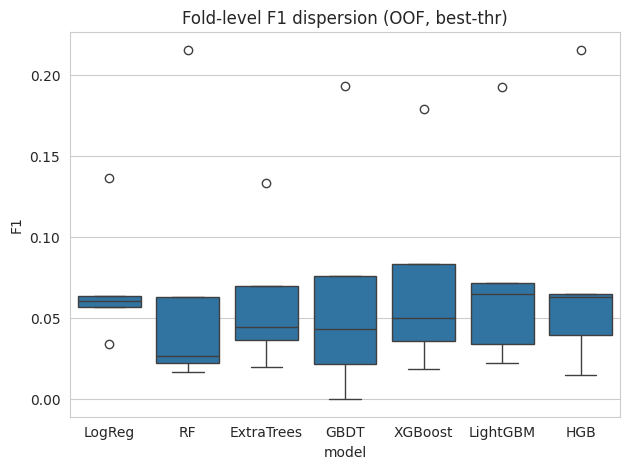

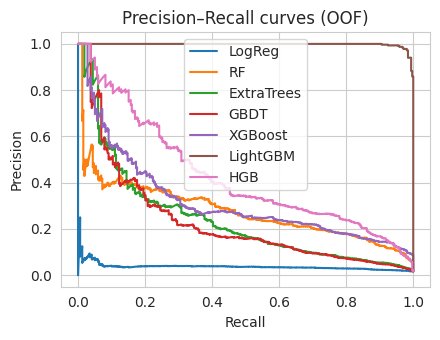

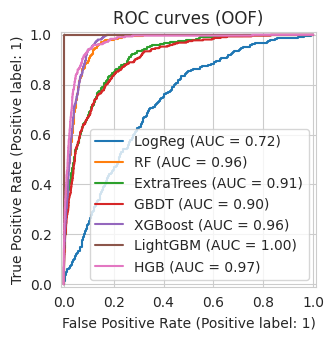


 Model comparison + 95% CI on F1
     model  best_thr  precision   recall  best_F1  roc_auc   pr_auc    brier                                                              F1_CI95
      GBDT      0.60   0.108303 0.101010 0.104530 0.781029 0.058185 0.035786  (np.float64(-0.006969498007385527), np.float64(0.1611761585272237))
       HGB      0.65   0.072197 0.158249 0.099156 0.775023 0.049751 0.046889 (np.float64(-0.005625014486137059), np.float64(0.15258570538421956))
        RF      0.75   0.074856 0.131313 0.095355 0.772348 0.050081 0.074559 (np.float64(-0.027443420623689874), np.float64(0.16123988843550296))
  LightGBM      0.45   0.057692 0.171717 0.086367 0.738872 0.044122 0.039040  (np.float64(-0.03544847110952602), np.float64(0.17314723653829528))
   XGBoost      0.95   0.048907 0.158249 0.074722 0.741445 0.047445 0.138165   (np.float64(0.02235037867381951), np.float64(0.11850850307701458))
    LogReg      0.65   0.039065 0.427609 0.071590 0.748937 0.038428 0.195068  (np.float64(

In [ ]:
# Models
from sklearn.linear_model      import LogisticRegression
from sklearn.ensemble          import (RandomForestClassifier,
                                       ExtraTreesClassifier,
                                       GradientBoostingClassifier,
                                       HistGradientBoostingClassifier)
from xgboost                   import XGBClassifier
from lightgbm                  import LGBMClassifier

MODELS = {
    "LogReg"   : LogisticRegression(max_iter=400, class_weight="balanced"),
    "RF"       : RandomForestClassifier(n_estimators=400, class_weight="balanced",
                                       random_state=42),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=400, class_weight="balanced",
                                       random_state=42),
    "GBDT"     : GradientBoostingClassifier(random_state=42),
    "XGBoost"  : XGBClassifier(eval_metric="logloss", learning_rate=0.05,
                               subsample=0.8, colsample_bytree=0.8,
                               max_depth=4, n_estimators=500,
                               scale_pos_weight=(y==0).sum()/(y==1).sum(),
                               random_state=42, n_jobs=-1),
    "LightGBM" : LGBMClassifier(n_estimators=400, learning_rate=0.05,
                                num_leaves=63, class_weight="balanced",
                                random_state=42),
    "HGB"      : HistGradientBoostingClassifier(max_depth=None, learning_rate=0.07,
                                                l2_regularization=0.,
                                                class_weight={0:1, 1:3},
                                                random_state=42)
}

# petite grids
grids = {
    "LogReg"   : {"clf__C":[0.1,1,10]},
    "RF"       : {"clf__max_depth":[None,10]},
    "ExtraTrees": {"clf__max_depth":[None,10]},
    "GBDT"     : {"clf__learning_rate":[0.05,0.1]},
    "XGBoost"  : {"clf__max_depth":[3,4]},
    "LightGBM" : {"clf__num_leaves":[31,63]},
    "HGB"      : {"clf__max_depth":[None,10]}
}

# Benchmark
fold_scores  = []
summary_rows = []
tuned_models = {}

print("Running 7‑model benchmark with tuning & fold metrics")
for name in tqdm(MODELS):

    pipe = build_pipe(MODELS[name])
    gcv  = GridSearchCV(pipe, grids[name],
                        scoring="average_precision",
                        cv=3, n_jobs=-1, error_score="raise")

    # OOF evaluation
    p_oof, y_oof = oof_pred(gcv)
    thr, f1_best = best_thr(p_oof, y_oof)

    P, R, _, _ = precision_recall_fscore_support(
                    y_oof, (p_oof >= thr).astype(int),
                    average="binary", zero_division=0)
    roc   = roc_auc_score(y_oof, p_oof)
    prauc = average_precision_score(y_oof, p_oof)
    brier = ((p_oof - y_oof) ** 2).mean()

    summary_rows.append([name, thr, P, R, f1_best, roc, prauc, brier])

    # fold‑level F1 distribution
    for k, (_, te) in enumerate(tscv.split(X_raw)):
        f1_fold = precision_recall_fscore_support(
                      y[te], (p_oof[te] >= thr).astype(int),
                      average="binary", zero_division=0)[2]
        fold_scores.append([name, k, f1_fold])

    # fit tuned model on full data for later plots
    gcv.fit(X_raw, y)
    tuned_models[name] = (gcv.best_estimator_, thr)

# Reporting
df_sum  = pd.DataFrame(summary_rows, columns=
        ["model","best_thr","precision","recall","best_F1",
         "roc_auc","pr_auc","brier"])
df_fold = pd.DataFrame(fold_scores, columns=["model","fold","F1"])

print("\n=== 7‑model comparison (tuned OOF) ===")
print(df_sum.sort_values("best_F1", ascending=False).to_string(index=False))

# Visuals
sns.boxplot(data=df_fold, x="model", y="F1")
plt.title("Fold‑level F1 dispersion (OOF, best‑thr)")
plt.tight_layout(); plt.show()

# Precision–Recall overlay
pal = sns.color_palette("tab10", n_colors=len(MODELS))
plt.figure(figsize=(4.5,3.5))
for c,(name, (model, thr)) in zip(pal, tuned_models.items()):
    pr, rc, _ = precision_recall_curve(y, model.predict_proba(X_raw)[:,1])
    plt.plot(rc, pr, label=name, c=c)
plt.title("Precision–Recall curves (OOF)"); plt.xlabel("Recall"); plt.ylabel("Precision")
plt.legend(); plt.tight_layout(); plt.show()

# ROC overlay
plt.figure(figsize=(4.5,3.5))
for c,(name,(model,thr)) in zip(pal, tuned_models.items()):
    RocCurveDisplay.from_predictions(
        y, model.predict_proba(X_raw)[:,1],
        name=name, color=c, ax=plt.gca(), plot_chance_level=False)
plt.title("ROC curves (OOF)"); plt.tight_layout(); plt.show()

# 8.I add 95 % CI for best‑thr F1
import scipy.stats as st

f1_folds = df_fold.groupby("model")["F1"]

df_sum["F1_CI95"] = (
    f1_folds
      .apply(lambda s: st.t.interval(0.95,
                       df=len(s)-1,
                       loc=s.mean(),
                       scale=st.sem(s)))
      .astype(str)
      .values
)

print("\n Model comparison + 95% CI on F1")
print(df_sum.sort_values("best_F1", ascending=False).to_string(index=False))

# 9- persist overall best pipeline
import joblib, os

best_name = df_sum.sort_values("best_F1", ascending=False)["model"].iloc[0]
best_pipe, best_thr = tuned_models[best_name]

out_path = f"/content/drive/MyDrive/silo_agg/output/best_{best_name}.joblib"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
joblib.dump(best_pipe, out_path)

print(f"\n Saved tuned {best_name} pipeline: {out_path}")
print(f"Best threshold(OOF) = {best_thr:.2f}")


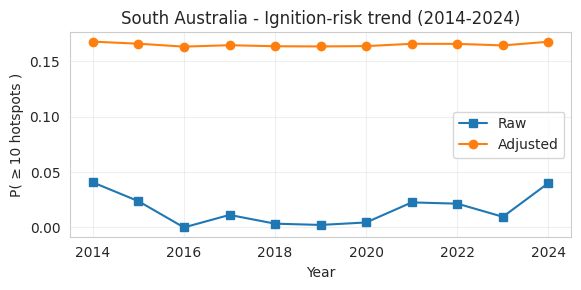

|      |    Raw |   Adjusted |
|-----:|-------:|-----------:|
| 2014 | 0.0406 |     0.1676 |
| 2015 | 0.0237 |     0.1657 |
| 2016 | 0      |     0.1631 |
| 2017 | 0.0113 |     0.1644 |
| 2018 | 0.0034 |     0.1634 |
| 2019 | 0.0023 |     0.1633 |
| 2020 | 0.0045 |     0.1636 |
| 2021 | 0.0226 |     0.1656 |
| 2022 | 0.0214 |     0.1656 |
| 2023 | 0.0096 |     0.1642 |
| 2024 | 0.0401 |     0.1675 |


In [ ]:
import pandas as pd, numpy as np, statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Read data & year column
df = pd.read_parquet(
    "/content/drive/MyDrive/silo_agg/output/panel_features_SA.parquet"
).copy()
df['year'] = df['date'].dt.year

num_cols = ['mean_temp','wind_speed','rel_humidity',
            'VPD','DTR','API','ndvi']

# Handling Numerical Features
X_num = df[num_cols].astype(float)

# a-First fill in the gaps with the column median
X_num = X_num.fillna(X_num.median())

# b) Standardization; if the column is constant, just set it to 0, which is equivalent to throwing it away in my training
scaler = StandardScaler()
X_num_z = pd.DataFrame(
    scaler.fit_transform(X_num),
    columns=num_cols, index=df.index
).replace([np.inf, -np.inf], 0.0)

# one‑hot year
X_year = pd.get_dummies(df['year'], prefix='yr').astype(float)

# Stitching & Final Inspection
X = pd.concat([X_num_z, X_year], axis=1)
X = sm.add_constant(X).astype(float)

X = X.fillna(0.0)
assert np.isfinite(X.values).all(), "Still has NaN/Inf!"

y = df['target_next_day'].astype(float)

# Ridge‑GLM
alpha = 0.1
n_num = len(num_cols)

pen = np.r_[ [0],
             np.ones(n_num),
             np.zeros(X_year.shape[1]) ]

glm = sm.GLM(y, X, family=sm.families.Binomial())
res = glm.fit_regularized(alpha=alpha, L1_wt=0,
                          pen_weights=pen, maxiter=500, disp=False)

# Extraction& Mapping
coef_year = res.params.filter(like='yr_')
base      = res.params['const']
p_year    = 1/(1+np.exp(-(base + coef_year)))
p_year.index = coef_year.index.str[-4:].astype(int)
p_year = p_year.sort_index()

raw = df.groupby('year')['target_next_day'].mean()

plt.figure(figsize=(6,3))
plt.plot(raw.index, raw, 's-', label='Raw')
plt.plot(p_year.index, p_year, 'o-', label='Adjusted')
plt.ylabel('P( ≥ 10 hotspots )'); plt.xlabel('Year')
plt.title('South Australia ‑ Ignition‑risk trend (2014‑2024)')
plt.legend(); plt.grid(alpha=.3); plt.tight_layout(); plt.show()

trend_tbl = pd.DataFrame({'Raw': raw, 'Adjusted': p_year}).round(4)
print(trend_tbl.to_markdown())
